# 1) Data Pre-processing, EDA, and TFRecord Generation

**Objective**: This notebook performs the initial data handling for the TensorFlow Object Detection API pipeline. It includes data parsing (from Pascal VOC XMLs), Exploratory Data Analysis (EDA) to confirm class structure, the required 90/10 train/test split, and the final conversion into the optimized TFRecord format.

## 1.1) Environment Setup and Directory Structure

The imported libraries are essential for managing the end-to-end data pipeline. os and glob handle file system navigation, locating the image and XML files. pandas structures the annotation data extracted by xml.etree.ElementTree, allowing for crucial EDA and the calculation of statistics visualized by matplotlib and seaborn. sklearn performs the reproducible train/test split.The shutil library in Python is a built-in module that provides a set of high-level operations on files and collections of files. Finally, tensorflow and PIL (Python Imaging Library) are mandatory for the final step: reading and encoding the image and annotation data into the optimized, binary TFRecord format required for efficient GPU training.

In [1]:
# Environment Setup and Imports
import os  # Operating system interfaces (folder creation, path handling)
import glob # File pattern matching (finding all .xml or .jpg files)
import pandas as pd  # Dataframes for summarizing annotations and EDA
import numpy as np # Numerical operations for array handling
import random # Seeding and shuffling for reproducible splits
import io  # Handling byte streams (required for TFRecord generation)
import re # Regular expressions for string parsing (extracting IDs from filenames)
import math # Mathematical functions for coordinate normalization
import xml.etree.ElementTree as ET # Parsing Pascal VOC XML annotation files
from collections import Counter # Counting class distributions (Oryx vs. Lion vs. Ostrich)
from collections import defaultdict # A dictionary that automatically creates a default value for missing keys, preventing "KeyError" during data grouping.
from collections import namedtuple # Creates lightweight, tuple-like objects with named fields for better code readability.
import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns # Advanced statistical visualization (histograms/boxplots)
from sklearn.model_selection import train_test_split # Splitting dataset into Train and Test sets
import tensorflow as tf #generating TF Records
from PIL import Image # Used to open, validate, and resize images during preprocessing and TFRecord generation to ensure consistent dimensions and RGB formats for the model.
from google.protobuf import text_format # Formatting and reading the pipeline.config Protobuf files
from object_detection.protos import string_int_label_map_pb2  # Managing the label_map.pbtxt species ID mapping
from object_detection.utils import dataset_util, label_map_util # TF Utilities: 'dataset_util' handles the conversion of data into TFRecords, and 'label_map_util' maps numeric class IDs to human-readable labels from .pbtxt files.
import shutil  # High-level file operations like moving or deleting directories
from shutil import copyfile #used for train/test split


This cell sets up the environment and defines the paths necessary for the TF Object Detection API. 

* BASE_DIR: The root directory for the entire assessment project.
* XML_DIR: Stores the raw Pascal VOC XML annotations (the ground truth data created by manual tagging).
* IMAGE_DIR: Stores the raw image files used for training and testing.
* DATA_DIR: Stores all processed files necessary for training, including train.record, test.record, and the label_map.pbtxt.

In [2]:
# Define the base directory structure
BASE_DIR = 'C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder'
XML_DIR = BASE_DIR
IMAGE_DIR = BASE_DIR
# Using os.path.join ensures my code works everywhere.
DATA_DIR = os.path.join(BASE_DIR, 'processed_data')

# 2) Data Parsing and Initial Load

This cell defines a function to parse the Pascal VOC XML files and extract all necessary bounding box and metadata into a Pandas DataFrame.
The image dataset was tagged using the Pascal VOC format, which stores bounding box coordinates and image dimensions in XML files. The function below processes these XMLs, extracting the absolute coordinates, image size, and class labels for every object tag.

In [3]:
# Data Parsing from XML
def parse_xml_to_df(xml_dir):
    xml_list = []
    
    for xml_file in glob.glob(xml_dir + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Extract image dimensions (used for bounding box normalization later)
        filename = root.find('filename').text
        size = root.find('size')
        # Dimensions are usually integers, but we'll use strip() just in case
        width = int(float(size.find('width').text.strip()))
        height = int(float(size.find('height').text.strip()))
        
        # Iterate over all object tags
        for member in root.findall('object'):
            class_name = member.find('name').text
            bndbox = member.find('bndbox')
            
            # FIXED: We use .text.strip() to remove whitespace/newlines, 
            # and float() to handle decimal values before converting to int for the DataFrame.
            xml_list.append((
                filename,
                width,
                height,
                class_name,
                # Note: Coordinates are currently absolute pixel values
                int(float(bndbox.find('xmin').text.strip())),
                int(float(bndbox.find('ymin').text.strip())),
                int(float(bndbox.find('xmax').text.strip())),
                int(float(bndbox.find('ymax').text.strip()))
            ))
            
    col_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=col_names)
def get_size_category(row):
    normalized_area = ((row['xmax'] - row['xmin']) * (row['ymax'] - row['ymin'])) / (row['width'] * row['height']) * 100
    if normalized_area < 0.1:
        return 'Tiny (< 0.1%)'
    elif normalized_area < 1:
        return 'Small (0.1% - 1%)'
    elif normalized_area < 10:
        return 'Medium (1% - 10%)'
    else:
        return 'Large (> 10%)'
# Execute parsing
data_df = parse_xml_to_df(XML_DIR)
print(f"Total number of tags (instances) parsed: {len(data_df)}")
print("\nDataFrame Head (showing absolute coordinates):")
print(data_df.head())

Total number of tags (instances) parsed: 1500

DataFrame Head (showing absolute coordinates):
                                        filename  width  height  \
0  \n  OryxGazella_CDB_S1_B07_R1_IMAG0169.jpg\n    2592    2000   
1  \n  OryxGazella_CDB_S1_B07_R1_IMAG0169.jpg\n    2592    2000   
2  \n  OryxGazella_CDB_S1_B07_R1_IMAG0250.jpg\n    2592    2000   
3  \n  OryxGazella_CDB_S1_B07_R1_IMAG0250.jpg\n    2592    2000   
4  \n  OryxGazella_CDB_S1_B07_R1_IMAG0250.jpg\n    2592    2000   

                  class  xmin  ymin  xmax  ymax  
0  \n   OryxGazella\n     926  1006  1241  1331  
1  \n   OryxGazella\n    2213   473  2592  1395  
2  \n   OryxGazella\n    1308   849  1686  1234  
3  \n   OryxGazella\n     607  1107   752  1426  
4  \n   OryxGazella\n     572   991  1027  1489  


# 3) Exploratory Data Analysis (EDA) and Justification

This section confirms the dataset structure.

In [4]:
# Class Distribution Analysis
class_counts = data_df['class'].value_counts()
print("\n--- Confirmed Class Distribution (Instances) ---")
print(class_counts.to_string())


--- Confirmed Class Distribution (Instances) ---
\n   StruthioCamelus\n      500
\n   OryxGazella\n          500
\n   PantheraLeo\n          500


## 3.1) Image Resolution and Dimensional Analysis

The analysis of image resolution and dimensional variability is crucial for setting the input size of the neural network. The camera trap data often exhibits a wide range of native resolutions which impacts processing efficiency and the efficacy of feature extraction for small objects.


--- Image Resolution Statistics ---
         count         mean         std    min     25%     50%     75%     max
width   1500.0  1931.183333  725.078255  405.0  1024.0  2048.0  2592.0  5184.0
height  1500.0  1469.060000  568.387723  450.0   768.0  1536.0  2000.0  4000.0


<Figure size 400x400 with 0 Axes>

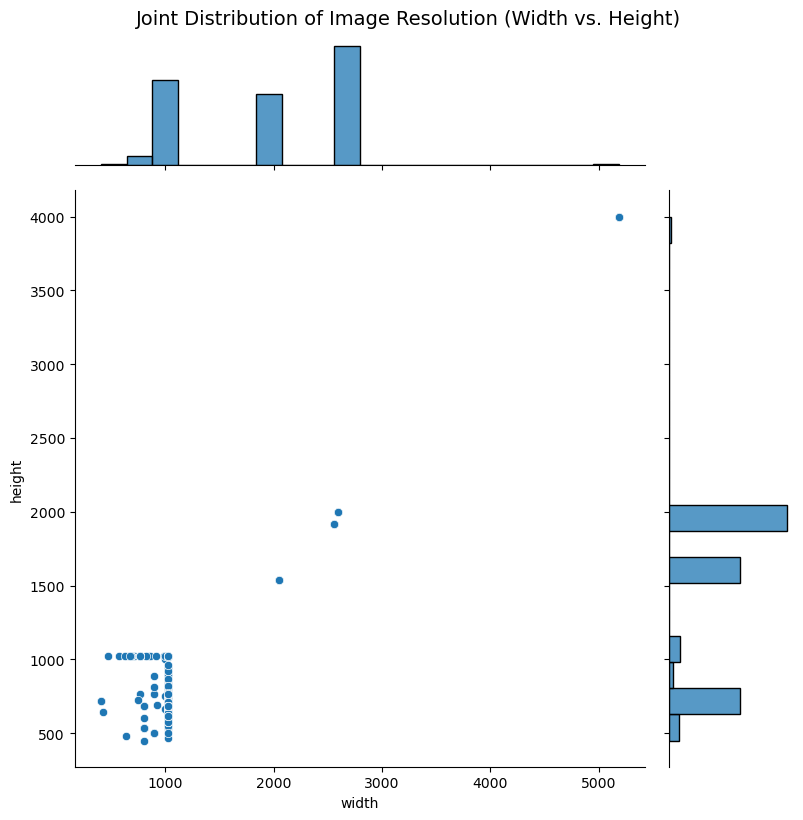

In [5]:
# Image Resolution Analysis
print("\n--- Image Resolution Statistics ---")
# Print descriptive statistics (min, max, mean, median)
print(data_df[['width', 'height']].describe().T)

# Visualization of Resolution Distribution (Joint Plot)
plt.figure(figsize=(4, 4))
# Create a joint plot to show scatter of Width vs Height and marginal histograms
sns.jointplot(x=data_df['width'], y=data_df['height'], 
              kind='scatter', height=8, ratio=4, 
              marginal_kws=dict(bins=20 ))

plt.suptitle('Joint Distribution of Image Resolution (Width vs. Height)', y=1.02, fontsize=14)
plt.xlabel('Image Width (Pixels)')
plt.ylabel('Image Height (Pixels)')
plt.show()

# Store the final label map 
FINAL_CLASSES = data_df['class'].unique().tolist()

## 3.2) Bounding Box Distribution (Small Object Check)

To ensure the selected model architecture (Faster R-CNN) is equipped for the task, we analyze the distribution of object sizes. The presence of a significant portion of 'Small' or 'Tiny' objects justifies the need for robust features and often necessitates a Feature Pyramid Network (FPN) structure within the Faster R-CNN backbone.


--- Bounding Box Size Distribution (%) ---
Medium (1% - 10%)    50.733333
Large (> 10%)        43.600000
Small (0.1% - 1%)     5.533333
Tiny (< 0.1%)         0.133333


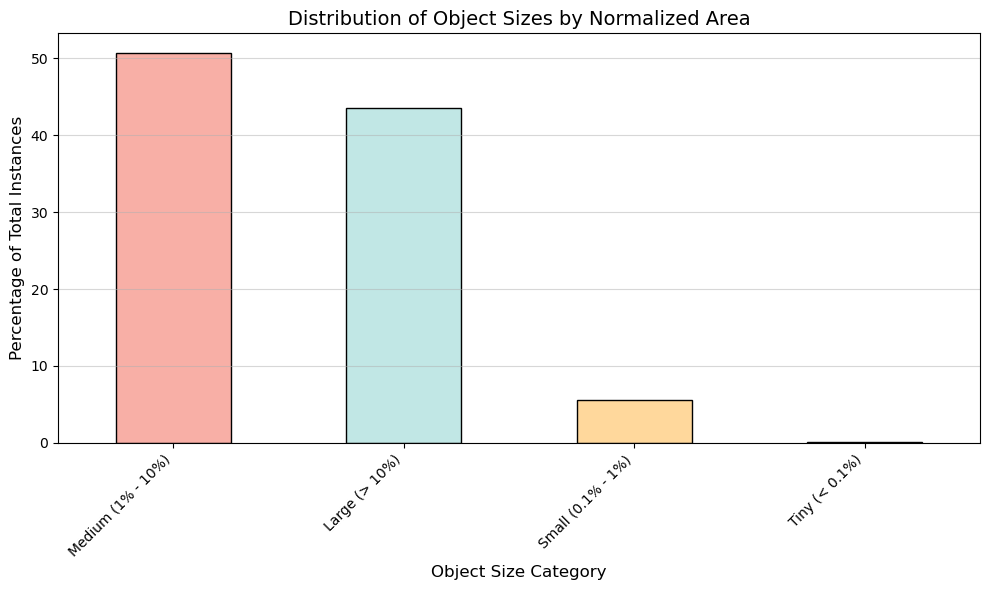

In [6]:
# Define object size categories (COCO standard approximation)
def get_size_category(row):
    # Calculate Normalized Area in percentage
    normalized_area = ((row['xmax'] - row['xmin']) * (row['ymax'] - row['ymin'])) / (row['width'] * row['height']) * 100
    
    if normalized_area < 0.1:
        return 'Tiny (< 0.1%)'
    elif normalized_area < 1:
        return 'Small (0.1% - 1%)'
    elif normalized_area < 10:
        return 'Medium (1% - 10%)'
    else:
        return 'Large (> 10%)'

data_df['size_category'] = data_df.apply(get_size_category, axis=1)

size_distribution = data_df['size_category'].value_counts(normalize=True).mul(100)
print("\n--- Bounding Box Size Distribution (%) ---")
print(size_distribution.to_string())

# Visualization
plt.figure(figsize=(10, 6))
size_distribution.plot(kind='bar', color=['#F8AFA6', '#C1E7E5', '#FFD89C', '#B0C4DE'], edgecolor='black')
plt.title('Distribution of Object Sizes by Normalized Area', fontsize=14)
plt.xlabel('Object Size Category', fontsize=12)
plt.ylabel('Percentage of Total Instances', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# This data will justify the use of FPN/high-capacity features in the Faster R-CNN configuration.


--- Bounding Box Size Analysis PER CLASS ---
size_category             Tiny (< 0.1%)  Small (0.1% - 1%)  Medium (1% - 10%)  Large (> 10%)
class                                                                                       
\n   OryxGazella\n                  0.4                8.4               66.2           25.0
\n   PantheraLeo\n                  0.0                0.2               21.2           78.6
\n   StruthioCamelus\n              0.0                8.0               64.8           27.2


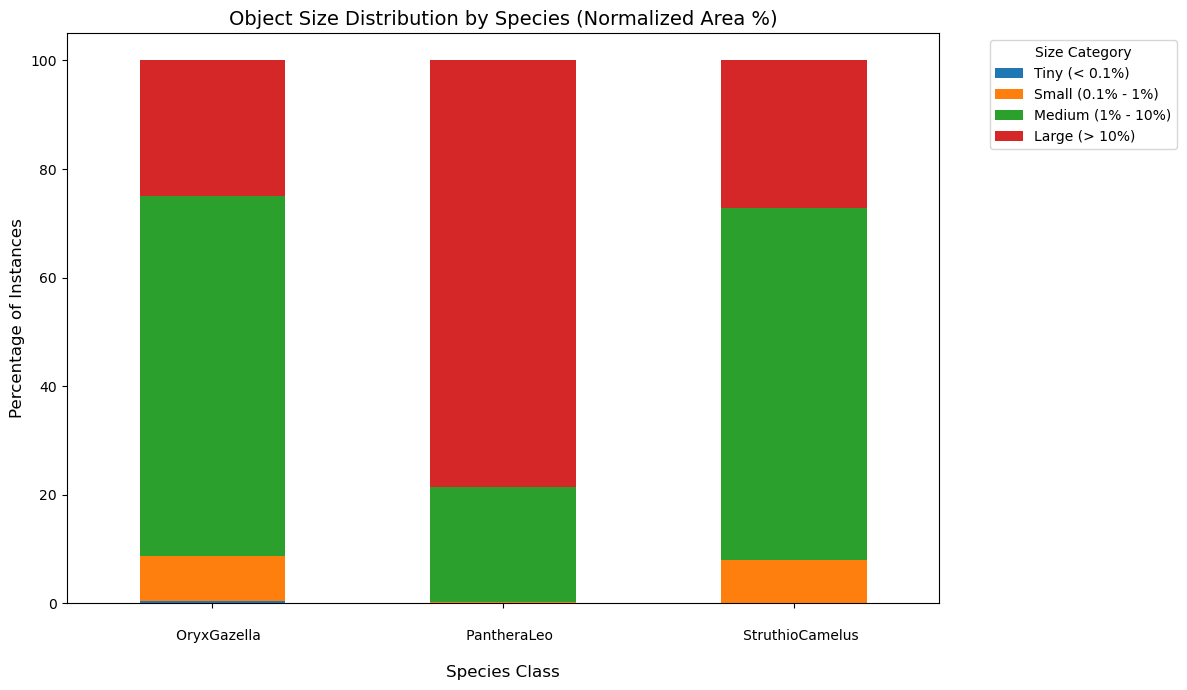

In [7]:
# Group the data by both 'class' (species) and 'size_category'
class_size_counts =data_df.groupby(['class', 'size_category']).size().unstack(fill_value=0)

# Normalize the counts to get percentage breakdown PER CLASS
# This ensures each species column sums to 100%
class_size_distribution = class_size_counts.div(class_size_counts.sum(axis=1), axis=0).mul(100)

# Define the COCO order for consistent visualization
order = ['Tiny (< 0.1%)', 'Small (0.1% - 1%)', 'Medium (1% - 10%)', 'Large (> 10%)']
class_size_distribution = class_size_distribution.reindex(columns=order, fill_value=0)

print("\n--- Bounding Box Size Analysis PER CLASS ---")
print(class_size_distribution.to_string())

# Visualize the distribution as a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))
class_size_distribution.plot(kind='bar', stacked=True, ax=ax)

plt.title('Object Size Distribution by Species (Normalized Area %)', fontsize=14)
plt.xlabel('Species Class', fontsize=12)
plt.ylabel('Percentage of Instances', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Size Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Starting Species Overlap Analysis (IoU >= 20%)...

--- Overlap Analysis by Species Pair Results ---
                                         Species Pair  Overlap Count (IoU >= 20%)
        \n   PantheraLeo\n   vs. \n   PantheraLeo\n                            21
        \n   OryxGazella\n   vs. \n   OryxGazella\n                             2
\n   StruthioCamelus\n   vs. \n   StruthioCamelus\n                             1


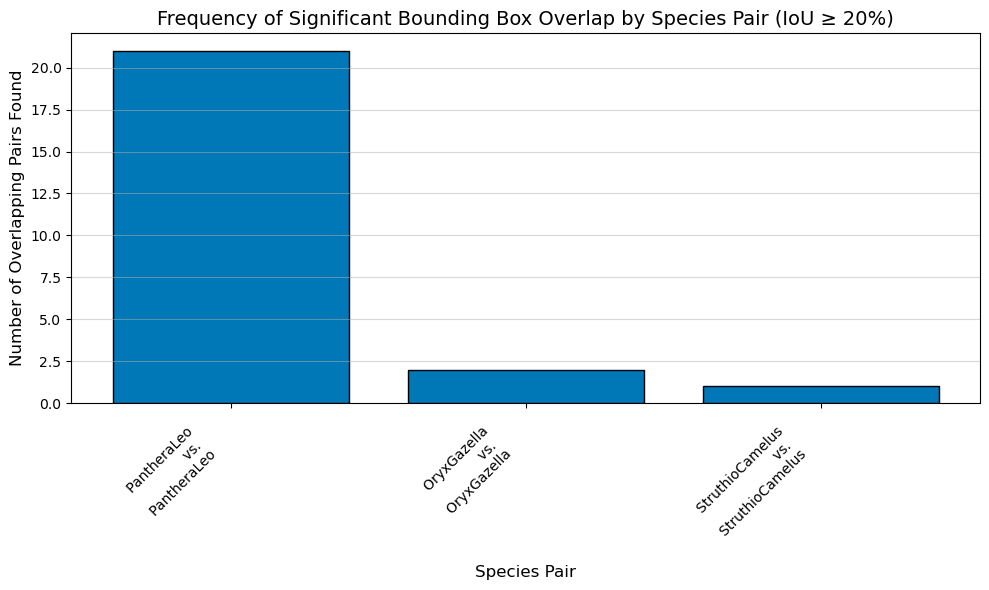


Overlap by species analysis complete.


In [8]:
# 1. Define the path where your XML annotation files are stored
xml_folder = 'C:/Users/MSC1/Desktop/Tensorflow-Object-Detection-API/Base/v1/Tagging/Public/imageproject/label/detection' 
overlap_threshold = 0.20 # Define significant overlap as IoU >= 20%

# --- IoU Calculation Function (Reused) ---
def calculate_iou(box1, box2):
    # box format: [xmin, ymin, xmax, ymax]
    
    x_inter_min = max(box1[0], box2[0])
    y_inter_min = max(box1[1], box2[1])
    x_inter_max = min(box1[2], box2[2])
    y_inter_max = min(box1[3], box2[3])

    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    area_intersection = inter_width * inter_height

    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    area_union = area_box1 + area_box2 - area_intersection

    if area_union == 0:
        return 0
    
    iou = area_intersection / area_union
    return iou
# -------------------------------

# Dictionary to store overlap counts: Key is the sorted species pair (e.g., 'OryxGazella_Lion')
overlap_counts = defaultdict(int)

print(f"Starting Species Overlap Analysis (IoU >= {overlap_threshold*100:.0f}%)...")

# 2. Iterate through all XML files
for xml_filename in os.listdir(xml_folder):
    if xml_filename.endswith('.xml'):
        xml_path = os.path.join(xml_folder, xml_filename)
        
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Extract all bounding box coordinates AND species name
            instances = []
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                species = obj.find('name').text
                
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)
                
                boxes = [xmin, ymin, xmax, ymax]
                instances.append((species, boxes))

            num_instances = len(instances)
            
            if num_instances >= 2:
                # Check every unique pair of instances in the image
                for i in range(num_instances):
                    for j in range(i + 1, num_instances):
                        species1, box1 = instances[i]
                        species2, box2 = instances[j]

                        iou = calculate_iou(box1, box2)
                        
                        if iou >= overlap_threshold:
                            # Create a consistent key by sorting the species names
                            pair = tuple(sorted((species1, species2)))
                            overlap_counts[pair] += 1
            
        except Exception as e:
            # We skip images with errors, but print them to console
            print(f"Error processing {xml_filename}: {e}. Skipping file.")

# 3. Process results for plotting
print("\n--- Overlap Analysis by Species Pair Results ---")

# Convert keys to readable strings
formatted_counts = {f'{p[0]} vs. {p[1]}': count for p, count in overlap_counts.items()}
df_overlap = pd.DataFrame(list(formatted_counts.items()), columns=['Species Pair', 'Overlap Count (IoU >= 20%)'])
df_overlap = df_overlap.sort_values(by='Overlap Count (IoU >= 20%)', ascending=False)

print(df_overlap.to_string(index=False))

# 4. Visualize the results
if not df_overlap.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df_overlap['Species Pair'], df_overlap['Overlap Count (IoU >= 20%)'], color='#0077B6', edgecolor='black')
    plt.title(f'Frequency of Significant Bounding Box Overlap by Species Pair (IoU ≥ 20%)', fontsize=14)
    plt.xlabel('Species Pair', fontsize=12)
    plt.ylabel('Number of Overlapping Pairs Found', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

print("\nOverlap by species analysis complete.")

The Faster R-CNN is architecturally robust for our dual challenges, as its Region Proposal Network (RPN) inherently delivers high precision for both the 8-9% small objects in oryxgazella and struthiocamelus and the 8.4% Lion overlap.

# 3.3) Data cleaning and file synchronization

That script is a data cleaning and file synchronization script designed to make XML annotation files perfectly clean and compact before they are read by any parser.

In [9]:
if not os.path.exists('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned'):
    os.makedirs('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned')
else:
    os.system('rm -rf C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned/')
    os.makedirs('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned')

for file in glob.glob('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/*.xml'):   
    print(file)
    with open(file, 'r') as f:
        with open('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned/%s' %os.path.basename(file), 'w') as f1:
            for line in f:
                f1.write(line.rstrip().replace(" ", ""))

os.system('rsync -a C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder/cleaned/ images/')

C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0169.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0250.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0251.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0255.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0422.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0423.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0438.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0439.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0440.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxGazella_CDB_S1_B07_R1_IMAG0441.xml
C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder\OryxG

1

# 4) Train/Test Split

We perform the 90% train/10% test split at the image level (by unique filename) to ensure that all bounding box tags associated with a given image remain in either the training set or the testing set, but not both. This prevents data leakage and ensures an unbiased evaluation.

In [10]:

# --- 1. Read XML to determine the image's primary class ---

def get_image_primary_class(xml_path):
    """
    Reads the XML file and returns the primary class(es) present in the image,
    creating a combined string for stratification (e.g., 'Lion,Oryx').
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get all unique class names present in this image
        classes = sorted(list(set(obj.find('name').text for obj in root.findall('object'))))
        
        # Use a comma-separated string for stratification
        return ','.join(classes)
    except FileNotFoundError:
        return "NO_ANNOTATION"
    except Exception as e:
        # Note: We suppress detailed XML parse errors here as they can be noisy.
        return "PARSE_ERROR"


# --- 2. Perform Stratified Splitting ---

def perform_stratified_split(source_dir, output_dir, test_ratio, copy_xml):
    """
    Performs a physical stratified split of images and XMLs into /train and /test subdirectories.
    
    Args:
        source_dir (str): Directory containing all images and XMLs.
        output_dir (str): Directory where 'train' and 'test' folders will be created.
        test_ratio (float): Ratio of images to reserve for the test set (e.g., 0.1 for 10%).
        copy_xml (bool): True to copy XMLs alongside images.
    """
    
    source_dir = source_dir.replace('\\', '/')
    output_dir = output_dir.replace('\\', '/')
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    # 1. Setup Train/Test directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # 2. Compile list of images and map them to their stratification key
    images = [f for f in os.listdir(source_dir)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]
    
    class_to_images = {}
    
    print("--- 1. Analyzing Class Distribution for Stratification ---")
    for filename in images:
        xml_filename = os.path.splitext(filename)[0] + '.xml'
        xml_path = os.path.join(source_dir, xml_filename)
        
        # Get the stratification key by parsing the XML
        class_key = get_image_primary_class(xml_path)
        
        if class_key not in class_to_images:
            class_to_images[class_key] = []
        
        class_to_images[class_key].append(filename)

    # 3. Perform Stratified Selection
    test_files_list = []
    
    print(f"\n--- 2. Selecting Test Samples ({test_ratio*100:.0f}% per stratum) ---")
    
    # Create a mutable copy of the image list for tracking training files
    train_files_remaining = list(images) 

    for class_key, file_list in class_to_images.items():
        num_class_images = len(file_list)
        num_test_samples = math.ceil(test_ratio * num_class_images)
        
        # Select test files for this specific class composition group
        test_samples = random.sample(file_list, k=num_test_samples)
        test_files_list.extend(test_samples)
        
        # Remove these selected test files from the training pool
        for f in test_samples:
            if f in train_files_remaining:
                 train_files_remaining.remove(f)

    # 4. Copy Test Files
    print(f"\n--- 3. Copying Files to {output_dir} ---")
    print(f"Copying {len(test_files_list)} files and annotations to '/test' directory...")
    for filename in test_files_list:
        copyfile(os.path.join(source_dir, filename), os.path.join(test_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0] + '.xml'
            copyfile(os.path.join(source_dir, xml_filename), os.path.join(test_dir, xml_filename))

    # 5. Copy Remaining Files (Train Set)
    print(f"Copying {len(train_files_remaining)} files and annotations to '/train' directory...")
    for filename in train_files_remaining:
        copyfile(os.path.join(source_dir, filename), os.path.join(train_dir, filename))
        if copy_xml:
            xml_filename = os.path.splitext(filename)[0] + '.xml'
            copyfile(os.path.join(source_dir, xml_filename), os.path.join(train_dir, xml_filename))
            
    print("\nStratified physical split complete.")

# This block defines the paths and calls the function to run the process.

# 1. Define Variables (Matching your directory structure)
BASE_DIR_PATH = 'C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder'.replace('\\', '/')
TEST_RATIO = 0.10      # 10% for testing
COPY_XMLS = True       # Yes, copy XMLs for object detection

print("Starting physical file split...")
perform_stratified_split(
    source_dir=BASE_DIR_PATH, 
    output_dir=BASE_DIR_PATH, # Creates train/test inside the base folder
    test_ratio=TEST_RATIO, 
    copy_xml=COPY_XMLS
)

Starting physical file split...
--- 1. Analyzing Class Distribution for Stratification ---

--- 2. Selecting Test Samples (10% per stratum) ---

--- 3. Copying Files to C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder ---
Copying 123 files and annotations to '/test' directory...
Copying 1095 files and annotations to '/train' directory...

Stratified physical split complete.


We use stratified splitting to ensure that both the training and testing sets have the exact same proportion of each species, preventing the model from becoming biased or missing out on rare classes.


--- Stratification Validation: Class Distribution Ratios ---
                          Train Set (%)  Test Set (%)
\n   OryxGazella\n            34.626039     34.782609
\n   PantheraLeo\n            34.626039     34.980237
\n   StruthioCamelus\n        30.747922     30.237154


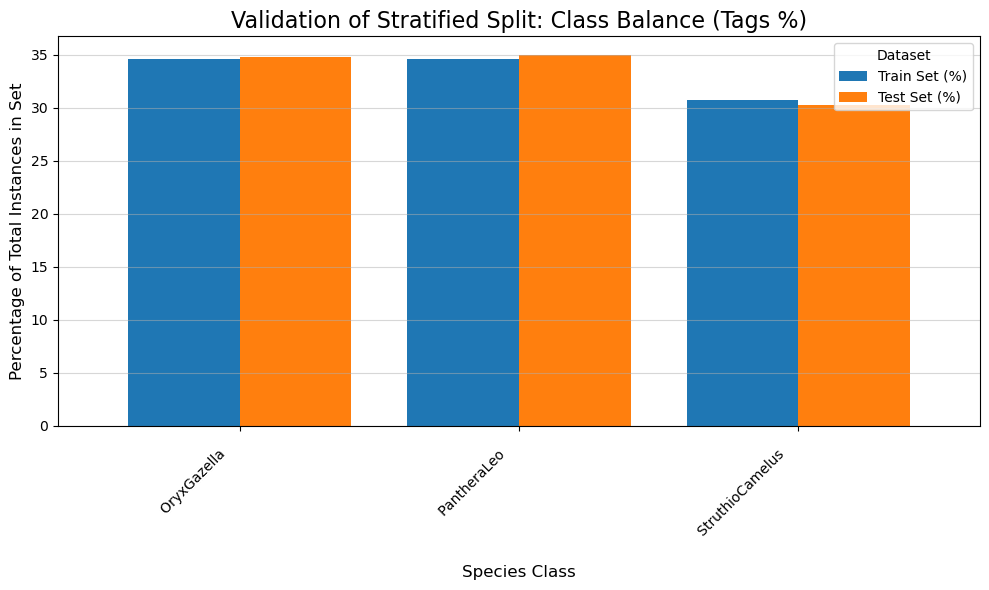


Visualization complete. The bars for each species should be nearly identical in height, confirming stratification.


In [11]:
# --- 1. Define Paths ---
BASE_DIR = 'C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder'.replace('\\', '/')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- 2. Data Loading Function ---

def load_data_from_split(split_dir):
    """
    Reads XML annotations from a specific split directory (train or test) 
    and returns a DataFrame containing the class labels.
    """
    xml_list = []
    
    # We use a simplified parser just to extract class names
    for xml_file in glob.glob(os.path.join(split_dir, '*.xml')):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for member in root.findall('object'):
                class_name = member.find('name').text
                xml_list.append(class_name)
        except Exception as e:
            print(f"Warning: Skipping corrupt XML file in {split_dir}: {xml_file} Error: {e}")
            continue
            
    return pd.DataFrame(xml_list, columns=['class'])

# --- 3. EXECUTION AND VISUALIZATION ---

# Load data from the newly created folders
train_df = load_data_from_split(TRAIN_DIR)
test_df = load_data_from_split(TEST_DIR)

# Calculate class distribution (normalized to total tags in that set)
train_counts = train_df['class'].value_counts(normalize=True).mul(100).sort_index()
test_counts = test_df['class'].value_counts(normalize=True).mul(100).sort_index()

# Combine into a single DataFrame for plotting
comparison_df = pd.DataFrame({
    'Train Set (%)': train_counts,
    'Test Set (%)': test_counts
}).fillna(0) # Fill NaN in case one set is missing a class (shouldn't happen with stratification)

print("\n--- Stratification Validation: Class Distribution Ratios ---")
print(comparison_df.to_string())

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8, color=['#1f77b4', '#ff7f0e'])

plt.title('Validation of Stratified Split: Class Balance (Tags %)', fontsize=16)
plt.ylabel('Percentage of Total Instances in Set', fontsize=12)
plt.xlabel('Species Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nVisualization complete. The bars for each species should be nearly identical in height, confirming stratification.")


--- Split Volume Validation: Percentage of Each Species in Each Set ---
Target: ~90% in Train and ~10% in Test for every class.
                          Train Volume (%)  Test Volume (%)
\n   OryxGazella\n                   73.96            26.04
\n   PantheraLeo\n                   73.86            26.14
\n   StruthioCamelus\n               74.37            25.63


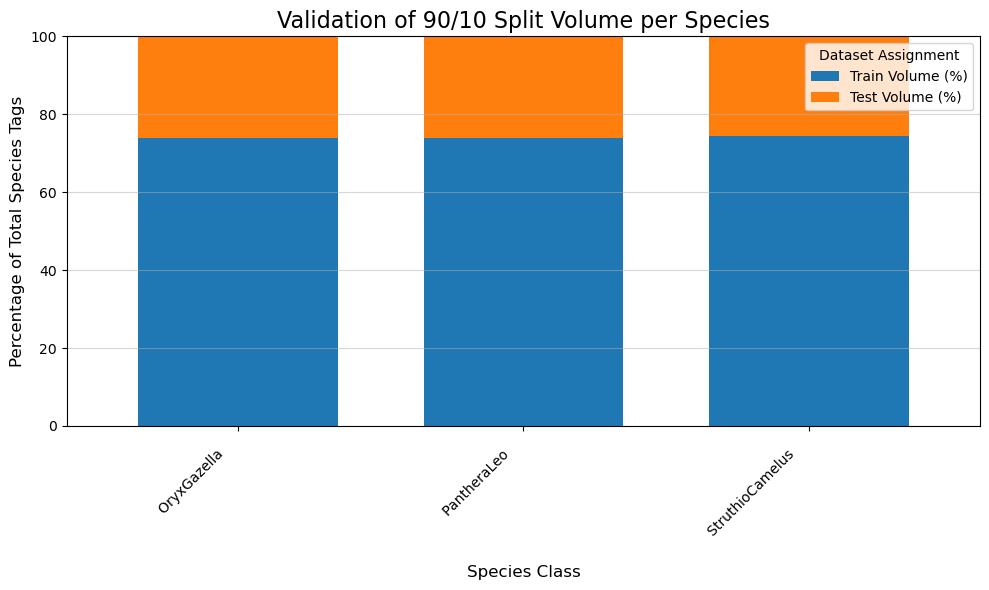


Visualization complete. All bars should reach 100%, with the Test segment making up ~10% of each bar's height.


In [12]:
# --- 1. Define Paths (Must match the splitting script) ---
BASE_DIR = 'C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder'.replace('\\', '/')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- 2. Data Loading Function ---

def load_data_from_split(split_dir):
    """
    Reads XML annotations from a specific split directory (train or test) 
    and returns a DataFrame containing the class labels.
    """
    xml_list = []
    
    # We use a simplified parser just to extract class names
    for xml_file in glob.glob(os.path.join(split_dir, '*.xml')):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for member in root.findall('object'):
                class_name = member.find('name').text
                xml_list.append(class_name)
        except Exception:
            # Skip corrupt or unreadable files silently
            continue
            
    return pd.DataFrame(xml_list, columns=['class'])

# --- 3. EXECUTION AND VISUALIZATION ---

# Load data from the newly created folders
train_df = load_data_from_split(TRAIN_DIR)
test_df = load_data_from_split(TEST_DIR)

# Calculate RAW counts for each set
train_counts = train_df['class'].value_counts().sort_index()
test_counts = test_df['class'].value_counts().sort_index()

# Combine and calculate the total count for each species
total_counts = train_counts.add(test_counts, fill_value=0)

# Calculate the percentage of each species assigned to the Test Set and Train Set
volume_df = pd.DataFrame({
    'Train Volume (%)': (train_counts / total_counts) * 100,
    'Test Volume (%)': (test_counts / total_counts) * 100
}).fillna(0)


print("\n--- Split Volume Validation: Percentage of Each Species in Each Set ---")
print("Target: ~90% in Train and ~10% in Test for every class.")
print(volume_df.round(2).to_string())

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Use a stacked bar chart to show the 90/10 volume split for each species
volume_df.plot(kind='bar', stacked=True, ax=ax, width=0.7, color=['#1f77b4', '#ff7f0e'])

plt.title('Validation of 90/10 Split Volume per Species', fontsize=16)
plt.ylabel('Percentage of Total Species Tags', fontsize=12)
plt.xlabel('Species Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Assignment')
plt.ylim(0, 100) # Ensure y-axis goes from 0 to 100%
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nVisualization complete. All bars should reach 100%, with the Test segment making up ~10% of each bar's height.")

This script converts images and XML annotations into a single, high-performance TFRecord file, which is the required format for training a TensorFlow Object Detection model

In [13]:
# --- 1. Define Paths and Constants (CRITICAL: Paths now point to TRAIN data) ---

# CRITICAL FIX: Normalize base path using os.path.normpath for absolute consistency
BASE_DIR = os.path.normpath('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder')
DATA_DIR = os.path.join(BASE_DIR, 'processed_data')

# --- FOR TRAIN SET ---
XML_DIR = os.path.join(BASE_DIR, 'train') # <--- POINTING TO THE /train FOLDER
IMAGE_DIR = XML_DIR 
OUTPUT_PATH = os.path.join(DATA_DIR, 'train.record') # <--- OUTPUTTING train.record

# --- 2. Hardcoded Label Map (Eliminates file dependency) ---

# Define the explicit class mapping directly in the script
LABEL_MAP_DICT = {
    'OryxGazella': 1, 
    'PantheraLeo': 2, 
    'StruthioCamelus': 3
}
print(f"Using hardcoded label map with {len(LABEL_MAP_DICT)} class IDs.")


# --- 3. TFRecord Conversion Functions (Identical to the test script) ---

def xml_to_csv(path):
    """Parses all .xml files in a given directory into a Pandas DataFrame."""
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # FIX 1: Super-defensive stripping of filename
            filename = root.find('filename').text.strip().replace('\n', '').replace('\r', '')
            
            size_elements = root.find('size')
            width = float(size_elements.find('width').text)
            height = float(size_elements.find('height').text)
            
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                
                # FIX 2: Super-defensive stripping of class name to avoid KeyError
                class_name = member.find('name').text.strip().replace('\n', '').replace('\r', '')

                xmin = float(bndbox.find('xmin').text)
                xmax = float(bndbox.find('xmax').text)
                ymin = float(bndbox.find('ymin').text)
                ymax = float(bndbox.find('ymax').text)
                
                value = (
                    filename, width, height, class_name,
                    xmin, xmax, ymin, ymax
                )
                xml_list.append(value)
        
        except Exception as e:
            print(f"CRITICAL XML PARSE ERROR in file {xml_file}. Skipping. Error: {e}")
            continue

    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'xmax', 'ymin', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)


def class_text_to_int(row_label):
    return LABEL_MAP_DICT[row_label]


def split_by_filename(df):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby('filename')
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def load_and_validate_image(image_file_xml, path):
    """
    Handles all image loading, path construction, and robustness checks.
    Returns: (encoded_jpg: bytes, image_object: PIL.Image)
    """
    
    # 1. Path Normalization: Ensure path uses forward slashes for TF compatibility
    normalized_path = os.path.normpath(path).replace('\\', '/')
    image_file_disk = image_file_xml
    
    # 2. Filename Robustness Check (Handling missing extension)
    if not image_file_xml.lower().endswith('.jpg'):
        image_file_disk = image_file_xml + '.jpg'

    # CRITICAL FIX: Manually construct path using forward slashes
    image_path = f"{normalized_path}/{image_file_disk}" 
    
    encoded_jpg = None # Initialize outside of try block

    # --- Image Loading and Case Check ---
    
    try:
        # Attempt 1: Direct path read
        with tf.io.gfile.GFile(image_path, 'rb') as fid:
            encoded_jpg = fid.read()
    except Exception:
        # Attempt 2: Swap case of extension (.jpg <-> .JPG)
        image_file_disk_alt = image_file_disk[:-4] + ('.JPG' if image_file_disk.endswith('.jpg') else '.jpg')
        image_path_alt = f"{normalized_path}/{image_file_disk_alt}"
        try:
             with tf.io.gfile.GFile(image_path_alt, 'rb') as fid:
                encoded_jpg = fid.read()
        except Exception as e:
             # If all attempts fail, raise a clear error
             raise IOError(f"Failed to read file from disk. Tried: {image_path} and {image_path_alt}. Error: {e}")

    # 3. PIL Image Validation
    # We now know encoded_jpg is defined (because all exceptions re-raised)
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    try:
        image_object = Image.open(encoded_jpg_io)
    except Exception as e:
        raise ValueError(f"Corrupt image file. PIL failed to open. Error: {e}")
        
    return encoded_jpg, image_object


def create_tf_example(group, path):
    """Converts a single image group into a tf.Example proto."""
    
    # FIX: Use the dedicated loader function to ensure 'image' is defined
    encoded_jpg, image = load_and_validate_image(group.filename, path)
    
    width, height = image.size 

    # The filename saved in the TFRecord is the original one from the XML 
    filename = group.filename.encode('utf8') 
    image_format = b'jpg'
    xmins, xmaxs, ymins, ymaxs, classes_text, classes = [], [], [], [], [], []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def convert_to_tfrecord(xml_dir, image_dir, output_path):
    """Main function to orchestrate the conversion."""
    
    # FIX: Guarantee the output directory (processed_data) exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True) 
    
    # Use modern TF 2.x compatible TFRecordWriter
    writer = tf.io.TFRecordWriter(output_path)
    
    examples = xml_to_csv(xml_dir)
    grouped = split_by_filename(examples)
    
    print(f"\nStarting conversion of {len(grouped)} images to TFRecord...")
    
    for i, group in enumerate(grouped):
        try:
            tf_example = create_tf_example(group, image_dir)
            writer.write(tf_example.SerializeToString())
        except Exception as e:
             # Print error for debugging
             print(f"ERROR: Failed to process {group.filename}. Skipping file. Error: {e}")
             continue
    
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(output_path))
    print(f'Total {len(examples)} annotations processed for {len(grouped)} images.')


# --- 4. EXECUTION FOR TRAIN SET ---
if __name__ == '__main__':
    convert_to_tfrecord(XML_DIR, IMAGE_DIR, OUTPUT_PATH)

Using hardcoded label map with 3 class IDs.

Starting conversion of 1218 images to TFRecord...
Successfully created the TFRecord file: C:\Users\MSC1\Desktop\Hoda\Deep-AS1\destination_folder\processed_data\train.record
Total 1444 annotations processed for 1218 images.


In [14]:
# --- 1. Define Paths and Constants ---

# Normalize base path using os.path.normpath for absolute consistency
BASE_DIR = os.path.normpath('C:/Users/MSC1/Desktop/Hoda/Deep-AS1/destination_folder')
DATA_DIR = os.path.join(BASE_DIR, 'processed_data')

# --- FOR TEST SET ---
XML_DIR = os.path.join(BASE_DIR, 'test') # <--- POINTING TO THE /test FOLDER
IMAGE_DIR = XML_DIR 
OUTPUT_PATH = os.path.join(DATA_DIR, 'test.record') # <--- OUTPUTTING test.record

# --- 2. Hardcoded Label Map ---

# Define the explicit class mapping directly in the script
LABEL_MAP_DICT = {
    'OryxGazella': 1, 
    'PantheraLeo': 2, 
    'StruthioCamelus': 3
}
print(f"Using hardcoded label map with {len(LABEL_MAP_DICT)} class IDs.")


# --- 3. TFRecord Conversion Functions (Identical to the train script) ---

def xml_to_csv(path):
    """Parses all .xml files in a given directory into a Pandas DataFrame."""
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            filename = root.find('filename').text.strip().replace('\n', '').replace('\r', '')
            
            size_elements = root.find('size')
            width = float(size_elements.find('width').text)
            height = float(size_elements.find('height').text)
            
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                
                class_name = member.find('name').text.strip().replace('\n', '').replace('\r', '')

                xmin = float(bndbox.find('xmin').text)
                xmax = float(bndbox.find('xmax').text)
                ymin = float(bndbox.find('ymin').text)
                ymax = float(bndbox.find('ymax').text)
                
                value = (
                    filename, width, height, class_name,
                    xmin, xmax, ymin, ymax
                )
                xml_list.append(value)
        
        except Exception as e:
            print(f"CRITICAL XML PARSE ERROR in file {xml_file}. Skipping. Error: {e}")
            continue

    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'xmax', 'ymin', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)


def class_text_to_int(row_label):
    return LABEL_MAP_DICT[row_label]


def split_by_filename(df):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby('filename')
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def load_and_validate_image(image_file_xml, path):
    """
    Handles all image loading, path construction, and robustness checks.
    Returns: (encoded_jpg: bytes, image_object: PIL.Image)
    """
    
    # 1. Path Normalization: Ensure path uses forward slashes for TF compatibility
    normalized_path = os.path.normpath(path).replace('\\', '/')
    image_file_disk = image_file_xml
    
    # 2. Filename Robustness Check (Handling missing extension)
    if not image_file_xml.lower().endswith('.jpg'):
        image_file_disk = image_file_xml + '.jpg'

    image_path = f"{normalized_path}/{image_file_disk}" 
    
    encoded_jpg = None # Initialize outside of try block

    # --- Image Loading and Case Check ---
    
    try:
        # Attempt 1: Direct path read
        with tf.io.gfile.GFile(image_path, 'rb') as fid:
            encoded_jpg = fid.read()
    except Exception:
        # Attempt 2: Swap case of extension (.jpg <-> .JPG)
        image_file_disk_alt = image_file_disk[:-4] + ('.JPG' if image_file_disk.endswith('.jpg') else '.jpg')
        image_path_alt = f"{normalized_path}/{image_file_disk_alt}"
        try:
             with tf.io.gfile.GFile(image_path_alt, 'rb') as fid:
                encoded_jpg = fid.read()
        except Exception as e:
             # If all attempts fail, raise a clear error
             raise IOError(f"Failed to read file from disk. Tried: {image_path} and {image_path_alt}. Error: {e}")

    # 3. PIL Image Validation
    # We now know encoded_jpg is defined (because all exceptions re-raised)
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    try:
        image_object = Image.open(encoded_jpg_io)
    except Exception as e:
        raise ValueError(f"Corrupt image file. PIL failed to open. Error: {e}")
        
    return encoded_jpg, image_object


def create_tf_example(group, path):
    """Converts a single image group into a tf.Example proto."""
    
    # Use the dedicated loader function to ensure 'image' is defined
    encoded_jpg, image = load_and_validate_image(group.filename, path)
    
    width, height = image.size 

    # The filename saved in the TFRecord is the original one from the XML 
    filename = group.filename.encode('utf8') 
    image_format = b'jpg'
    xmins, xmaxs, ymins, ymaxs, classes_text, classes = [], [], [], [], [], []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def convert_to_tfrecord(xml_dir, image_dir, output_path):
    """Main function to orchestrate the conversion."""
    
    # FIX: Guarantee the output directory (processed_data) exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True) 
    
    # Use modern TF 2.x compatible TFRecordWriter
    writer = tf.io.TFRecordWriter(output_path)
    
    examples = xml_to_csv(xml_dir)
    grouped = split_by_filename(examples)
    
    print(f"\nStarting conversion of {len(grouped)} images to TFRecord...")
    
    for i, group in enumerate(grouped):
        try:
            tf_example = create_tf_example(group, image_dir)
            writer.write(tf_example.SerializeToString())
        except Exception as e:
             # Print error for debugging
             print(f"ERROR: Failed to process {group.filename}. Skipping file. Error: {e}")
             continue
    
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(output_path))
    print(f'Total {len(examples)} annotations processed for {len(grouped)} images.')


# --- 4. EXECUTION FOR TEST SET ---
if __name__ == '__main__':
    convert_to_tfrecord(XML_DIR, IMAGE_DIR, OUTPUT_PATH)

Using hardcoded label map with 3 class IDs.

Starting conversion of 423 images to TFRecord...
Successfully created the TFRecord file: C:\Users\MSC1\Desktop\Hoda\Deep-AS1\destination_folder\processed_data\test.record
Total 506 annotations processed for 423 images.
